# Import Necessary Headers

In [1]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load Updated CSV into Pandas Dataframe

In [2]:
df = pd.read_csv("hong_et_al/df_updt.csv")

In [3]:
# Initial view of the frame
display(df)

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,NaN,Single,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,3.0,84.0,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560481,A,2.0,49.0,Male,Non-Hispanic,White or Caucasian,English,Episcopal,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560482,A,3.0,50.0,Male,Non-Hispanic,White or Caucasian,English,Episcopal,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560483,A,3.0,50.0,Male,Non-Hispanic,White or Caucasian,English,Episcopal,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
560484,A,3.0,50.0,Male,Non-Hispanic,White or Caucasian,English,Episcopal,Single,Disabled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocess Data

In [4]:
# Drop CKD information columns
df = df.drop(columns=df.filter(like='chrkidneydisease').columns)

# Exclude columns describing direct parameter to CKD-EPI Creatinine Equation used to calculate eGFR
df = df.drop(columns=df.filter(like='creat').columns)

# Drop rows with NaN eGFR values
df.dropna(subset=['egfr_CKD_EPI'])

# Impute median data for any remaining NaN values in numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Cast categorical columns as type category
categorical_cols = ['dep_name', 'gender', 'ethnicity', 'race', 'lang', 'religion',
                    'maritalstatus', 'employstatus', 'insurance_status', 'disposition', 'arrivalmode',
                    'arrivalmonth', 'arrivalday', 'arrivalhour_bin', 'previousdispo']

df[categorical_cols] = df[categorical_cols].astype('category')

# Define Training and Testing Data Sets

In [5]:
# Exclude target variable from features frame
X = df.drop(columns=df.filter(like='egfr').columns)

# Set target variable to egfr_CKD_EPI; calculated patient eGFR 
y = df['egfr_CKD_EPI']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor

In [6]:
# Initialize XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, enable_categorical=True)

# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluate Feature Importance

In [7]:
# Retrieve feature importances
importances = model.feature_importances_

# Create a frame for feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance frame
print(feature_importance.head(30))

                                 Feature  Importance
315                             bun_last    0.192658
479                              bun_max    0.045495
623                     troponint_median    0.041703
561                           bun_median    0.039067
622                troponini(poc)_median    0.027092
138                                  htn    0.024125
2                                    age    0.021115
330                         glucose_last    0.010510
459                        troponint_min    0.008312
5                                   race    0.008034
651                      proteinua_count    0.007807
196                           otdxkidney    0.007024
580                    hemoglobin_median    0.006631
724        meds_colonystimulatingfactors    0.006576
374                             rdw_last    0.006326
397                              bun_min    0.006092
416                       hemoglobin_min    0.005760
638                       ketonesua_npos    0.

# Visualize Feature Importance

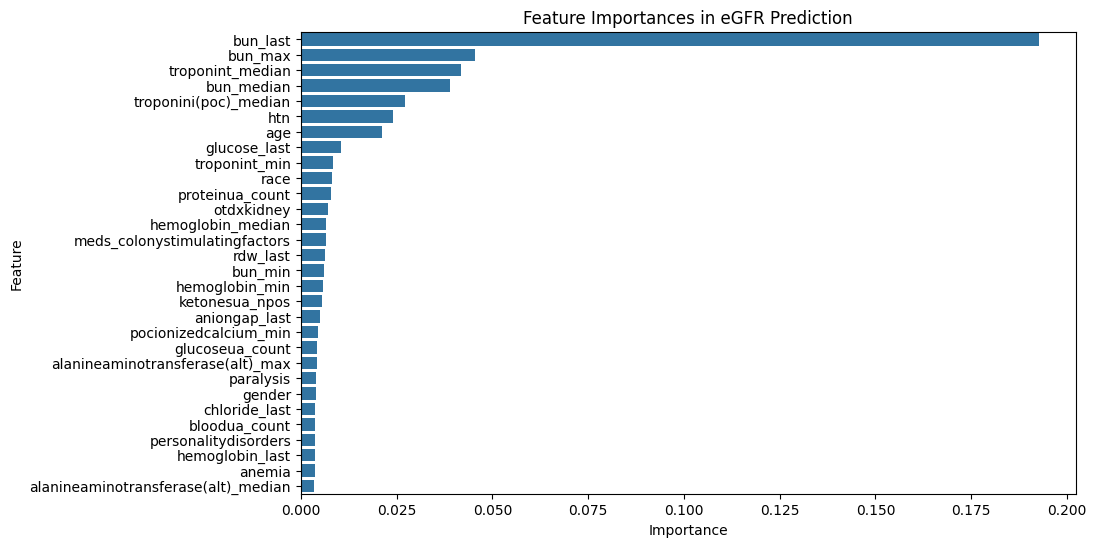

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(30))
plt.title('Feature Importances in eGFR Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()